# Introduction to RNNs
This notebook is part of the [SachsLab Workshop for Intracranial Neurophysiology and Deep Learning](https://github.com/SachsLab/IntracranialNeurophysDL).

### Normalize Environments
Run the first two cells to normalize Local / Colab environments, then proceed below for the lesson.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/06_01_intro_to_RNNs.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/06_01_intro_to_RNNs.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [1]:
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt

try:
    # See if we are running on google.colab
    import google.colab
    %tensorflow_version 2.x
    plt.style.use('dark_background')
    IN_COLAB = True
except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)

plt.rcParams.update({
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'lines.linewidth': 3,
    'lines.markersize': 10,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 18
})

import tensorflow as tf
%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.rcParams.update({
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'lines.linewidth': 3,
    'lines.markersize': 10,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 18
})

TensorFlow 2.x selected.


## RNN Step-by-Step
A recurrent neural network (RNN) is an artificial neural network that maintains an internal state (memory)
as it processes items in a sequence. RNNs are most often applied to sequence data such as text
(sequences of characters; sequences of words) or time series (e.g., stock prices, weather data, neurophysiology).
RNNs can provide an output at each step of the sequence to predict different sequences (e.g., text translation) or
the next item in the same sequence (e.g., assistive typing, stock prediction, prosthetic control).
The loss does not back-propagate to update weights until the sequence is complete. RNNs can also be configured
to produce a single output at the end of a sequence (e.g., classify a tweet sentiment, decode categorical intention).

We will create our own RNN step-by-step. We will train it using toy data that we generate.

### Generate data
X is a multi-channel time series and Y is a different multi-channel time series
constructed from a linear combination of a delayed version of X.

In [0]:
PEAK_FREQS = [10, 22, 75]  # Hz
FS = 1000.0  # Hz
DURATION = 5.0  # seconds
DELAY = 0.01  # seconds
N_OUT = 2  # Y dimensions

n_samples = int(DURATION * FS)
delay_samples = int(DELAY * FS)
t_vec = np.arange(n_samples + delay_samples) / FS

X = np.zeros((n_samples + delay_samples, len(PEAK_FREQS)), dtype=np.float32)
for chan_ix, pf in enumerate(PEAK_FREQS):
    X[:, chan_ix] = (1 / (chan_ix + 1) ) * np.sin(t_vec * 2 * np.pi * pf)

# Create mixing matrix that mixes inputs into outputs
W = 2 * np.random.rand(N_OUT, len(PEAK_FREQS)) - 1
# W = W / np.sum(W, axis=1, keepdims=True)

b = np.random.rand(N_OUT) - 0.5

Y = W @ X[:-delay_samples, :].T + b[:, None]
Y = Y.T
X = X[delay_samples:, :]
t_vec = t_vec[delay_samples:]

X += 0.05*np.random.rand(*X.shape)
Y += 0.05*np.random.rand(*Y.shape)

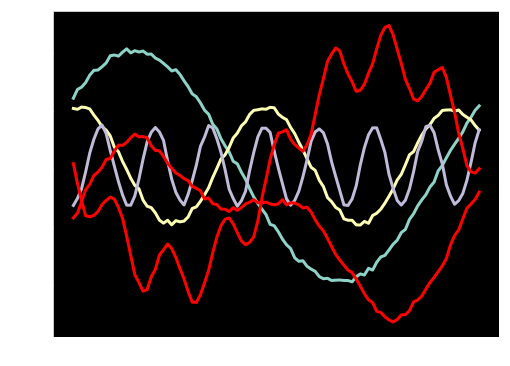

In [4]:
plt.figure(figsize=(8, 6))
plt.plot(t_vec[:100], X[:100, :])
plt.plot(t_vec[:100], Y[:100, :], 'r')
plt.show()

### Define forward pass and loss
We aren't actually going to run this next cell.
This is just to give you an indication of what the forward pass looks like.

In [5]:
activation_fn = lambda x: x
# activation_fn = np.tanh

# Initialize parameters
state_t = np.zeros((N_OUT,))
_W = np.random.random((N_OUT, X.shape[1]))  # Mixes input with output
_U = np.random.random((N_OUT, N_OUT))       # Mixes old state with output
_b = np.random.random((N_OUT,))             # Bias term

# Create variable to store output
successive_outputs = []

# Iterate over each timestep in X
for x_t in X:
    y_t = activation_fn(np.dot(_W, x_t) + np.dot(_U, state_t) + _b)
    successive_outputs.append(y_t)
    state_t = y_t
    
final_output_sequence = np.stack(successive_outputs, axis=0)
loss = np.mean( (Y - final_output_sequence)**2 )
print(loss)

2.0413226393059807


## RNN in Tensorflow
[Tutorial](https://www.tensorflow.org/tutorials/sequences/text_generation) (text generation w/ eager)

### Prepare data for Tensorflow
In the tutorial linked above, the `batch` transformation is used to convert a continuous sequence into
many sequences, then the batch transform is used AGAIN to get batches of sequences.

In [0]:
SEQ_LENGTH = 200
BATCH_SIZE = 2
BUFFER_SIZE = 10000

dataset = tf.data.Dataset.from_tensor_slices((X, Y))
dataset = dataset.batch(SEQ_LENGTH, drop_remainder=True)  # Continuous to segmented sequences
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)  # Segmented sequences to batches of seg. seq.

### Define RNN model in Tensorflow

In [7]:
inputs = tf.keras.layers.Input(shape=(SEQ_LENGTH, X.shape[-1]))
outputs = tf.keras.layers.SimpleRNN(N_OUT, return_sequences=True,
                                    activation='linear')(inputs)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='rmsprop', loss='mean_squared_error')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 3)]          0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 200, 2)            12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Just to save us some training time, let's cheat and init the model with good weights
old_init_weights = model.layers[-1].get_weights()
model.layers[-1].set_weights([W.T, old_init_weights[1], b])

In [9]:
EPOCHS = 50
history = model.fit(x=dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
12/12 [==============================] - 3s 258ms/step - loss: 0.2283
Epoch 2/50
12/12 [==============================] - 1s 120ms/step - loss: 0.2169
Epoch 3/50
12/12 [==============================] - 1s 114ms/step - loss: 0.2114
Epoch 4/50
12/12 [==============================] - 1s 115ms/step - loss: 0.2059
Epoch 5/50
12/12 [==============================] - 1s 112ms/step - loss: 0.2006
Epoch 6/50
12/12 [==============================] - 1s 111ms/step - loss: 0.1983
Epoch 7/50
12/12 [==============================] - 1s 110ms/step - loss: 0.1927
Epoch 8/50
12/12 [==============================] - 1s 110ms/step - loss: 0.1898
Epoch 9/50
12/12 [==============================] - 1s 109ms/step - loss: 0.1846
Epoch 10/50
12/12 [==============================] - 1s 114ms/step - loss: 0.1811
Epoch 11/50
12/12 [==============================] - 1s 114ms/step - loss: 0.1791
Epoch 12/50
12/12 [==============================] - 1s 106ms/step - loss: 0.1751
Epoch 13/50
12/12 [======

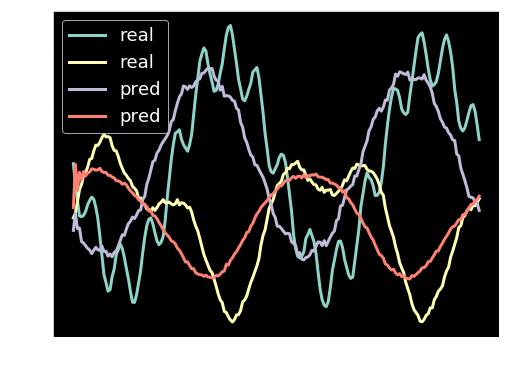

In [10]:
_Y1 = model.predict(X[:SEQ_LENGTH, :][None, :, :])

plt.figure(figsize=(8, 6))
plt.plot(Y[:SEQ_LENGTH, :], label='real')
plt.plot(_Y1[0], label='pred')
plt.legend()
plt.show()

[[-0.95486118  0.04707023 -0.77384562]
 [ 0.5435694   0.61090457  0.06648727]]
[[-1.0279001  -0.0023172  -0.19304623]
 [ 0.35944787  0.14719403 -0.07440079]]
[ 0.01197275 -0.47343409] [ 0.03459867 -0.6539719 ]


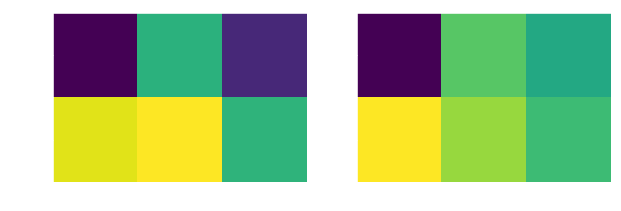

In [12]:
_W, _U, _b = model.layers[-1].get_weights()

print(W)
print(_W.T)
print(b, _b)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(W)
plt.subplot(1, 2, 2)
plt.imshow(_W.T)
plt.show()